In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-12-27 12:20:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 74.125.139.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   219MB/s    in 2.3s    

2023-12-27 12:20:23 (219 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



**Import necessary modules:**

In [3]:
import zipfile
import os
import numpy as np
import random
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

**Unzip the data:**

In [4]:
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

**Check for the number of images in each classes of training and test datasets:**

In [5]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/train
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_wings
There are 0 directories and 750 images in 10_food_classes_all_data/train/ramen
There are 0 directories and 750 images in 10_food_classes_all_data/train/steak
There are 0 directories and 750 images in 10_food_classes_all_data/train/sushi
There are 0 directories and 750 images in 10_food_classes_all_data/train/fried_rice
There are 0 directories and 750 images in 10_food_classes_all_data/train/chicken_curry
There are 0 directories and 750 images in 10_food_classes_all_data/train/ice_cream
There are 0 directories and 750 images in 10_food_classes_all_data/train/pizza
There are 0 directories and 750 images in 10_food_classes_all_data/train/hamburger
There are 0 directories and 750 images in 10_food_classes_all_data/train/grilled_salmon
There are 10 directories and 0 imag

**Check the names of each classes:**

In [6]:
data_dir = pathlib.Path('/kaggle/working/10_food_classes_all_data/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


**Create a function to visualize the random image:**

In [7]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + '/' + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    img = plt.imshow(img)
    plt.title(target_class)
    plt.axis(False) 

**Viewing a random image from training dataset:**

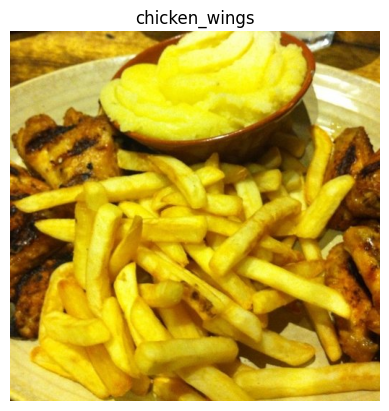

In [8]:
view_random_image('/kaggle/working/10_food_classes_all_data/train', 'chicken_wings')

**Making the train and test datasets:**
> **Batch_size = 32, label_mode = categorical, img_size = (224, 224), 'shuffle = True' for train_data and 'shuffle = False' for test dataset**

In [9]:
IMG_SIZE = (224, 224)
train_dir = '/kaggle/working/10_food_classes_all_data/train'
test_dir = '/kaggle/working/10_food_classes_all_data/test'
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size = 32,
                                                                 label_mode = 'categorical',
                                                                 shuffle = True,
                                                                 image_size = IMG_SIZE,
                                                                 seed = 42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size = 32,
                                                                label_mode = 'categorical',
                                                                shuffle = False,
                                                                image_size = IMG_SIZE,
                                                                seed = 42)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


2023-12-27 12:20:45.963996: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964107: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964183: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964309: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964400: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964602: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-27 12:20:45.964715: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

**Create a data augmentation layer:**

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2)])

**Create a function to visualize our model's metrics:**

In [11]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(history.history['loss']))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

**Create a function to visualize model's metrics after fine tuning:**

In [12]:
def compare_historys(original_history, new_history, initial_epochs = 10):
    accuracy = original_history.history['accuracy']
    val_accuracy = original_history.history['val_accuracy']
    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']
    
    total_accuracy = accuracy + new_history.history['accuracy']
    total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.plot(total_accuracy, label = 'Training accuracy')
    plt.plot(total_val_accuracy, label = 'Validation accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'fine tune epochs')
    plt.title('Training and validation accuracy')
    plt.legend();
    
    plt.figure()
    plt.plot(total_loss, label = 'Training loss')
    plt.plot(total_val_loss, label = 'Validation loss')
    plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label = 'fine tune epochs')
    plt.title('Training and validation loss')
    plt.legend();
    

**Create a function to create a model checkpoint callback:**
> **save_best_only = True, save_freq = 'epoch', restore_best_weights = True**

In [13]:
checkpoint_path = 'model_checkpoints_weights/checkpoint.ckpt'
def create_checkpoint_callback(model_name, save_path = checkpoint_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(checkpoint_path, model_name),
                                                         save_best_only = True,
                                                         save_freq = 'epoch',
                                                         verbose = 1,
                                                         restore_best_weights = True)

**Create a feature extractor model using EfficientnetV2B0 model:**

In [14]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'GAP2D')(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_for_fine_tuning')
model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_1 = model_1.fit(train_data,
            epochs = 10,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = int(0.25 * len(test_data)),
            callbacks = create_checkpoint_callback(model_name = model_1.name))

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 1.0881 - accuracy: 0.6860
Epoch 1: val_loss improved from inf to 0.66020, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 95s 374ms/step - loss: 1.0881 - accuracy: 0.6860 - val_loss: 0.6602 - val_accuracy: 0.7747
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7909
Epoch 2: val_loss improved from 0.66020 to 0.48143, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 84s 359ms/step - loss: 0.6726 - accuracy: 0.7909 - val_loss: 0.4814 - val_accuracy: 0.8372
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.8121
Epoch 3: val_loss improved from 0.48143 to 0.41062, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 84s 359ms/step - loss: 0.5967 - accuracy: 0.8121 - val_loss: 0.4106 - val_accuracy: 0.8569
Epoch 4/10
235/235 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.8281
Epoch 4: val_loss improved from 0.41062 to 0.40152, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 85s 363ms/step - loss: 0.5484 - accuracy: 0.8281 - val_loss: 0.4015 - val_accuracy: 0.8684
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.8335
Epoch 5: val_loss did not improve from 0.40152
235/235 [==============================] - 55s 234ms/step - loss: 0.5259 - accuracy: 0.8335 - val_loss: 0.4041 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8379
Epoch 6: val_loss improved from 0.40152 to 0.35665, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 83s 354ms/step - loss: 0.4979 - accuracy: 0.8379 - val_loss: 0.3566 - val_accuracy: 0.8865
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.8424
Epoch 7: val_loss improved from 0.35665 to 0.34767, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 83s 355ms/step - loss: 0.4934 - accuracy: 0.8424 - val_loss: 0.3477 - val_accuracy: 0.8799
Epoch 8/10
235/235 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8524
Epoch 8: val_loss improved from 0.34767 to 0.32981, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 84s 358ms/step - loss: 0.4697 - accuracy: 0.8524 - val_loss: 0.3298 - val_accuracy: 0.8849
Epoch 9/10
235/235 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8528
Epoch 9: val_loss did not improve from 0.32981
235/235 [==============================] - 56s 240ms/step - loss: 0.4542 - accuracy: 0.8528 - val_loss: 0.3345 - val_accuracy: 0.8832
Epoch 10/10
235/235 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8575
Epoch 10: val_loss improved from 0.32981 to 0.32150, saving model to model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning
INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


INFO:tensorflow:Assets written to: model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning/assets


235/235 [==============================] - 84s 356ms/step - loss: 0.4443 - accuracy: 0.8575 - val_loss: 0.3215 - val_accuracy: 0.8865


**Make evaluation on test Data:**

In [15]:
model_1.evaluate(test_data)

79/79 [==============================] - 14s 181ms/step - loss: 0.2772 - accuracy: 0.9100


[0.27724605798721313, 0.9100000262260437]

In [16]:
model_1 = tf.keras.models.load_model('/kaggle/working/model_checkpoints_weights/checkpoint.ckpt/model_for_fine_tuning')

In [17]:
model_1.evaluate(test_data)

79/79 [==============================] - 16s 181ms/step - loss: 0.2772 - accuracy: 0.9100


[0.27724605798721313, 0.9100000262260437]

**Plot the performance of our model:**

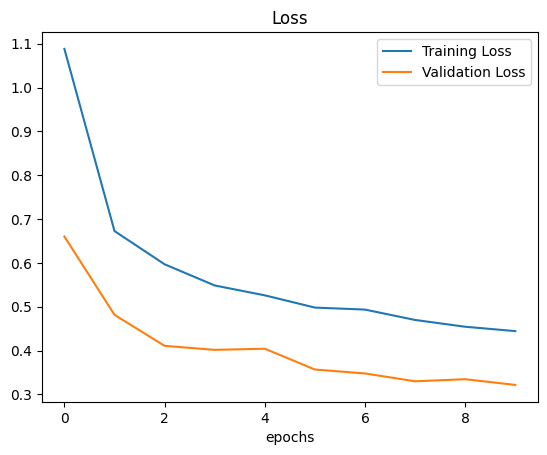

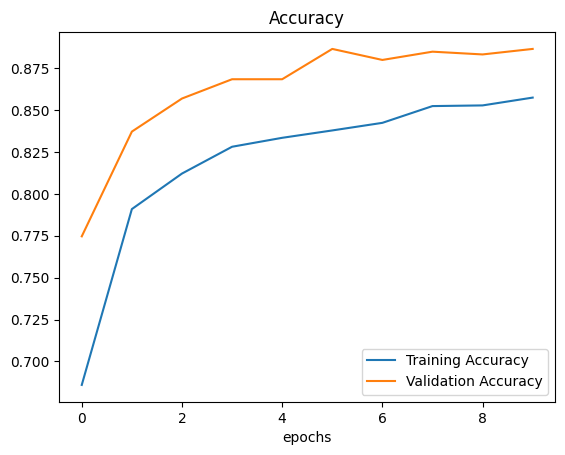

In [18]:
plot_loss_curves(history_1)

**Checkout the layers in our base model:**

In [19]:
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 False

**Fine tune for 10 layers by making last 10 layers in our base model trainable:**

In [20]:
model_1.layers[2].trainable = True
for layer in model_1.layers[2].layers[:-10]:
    layer.trainable = False

In [21]:
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

**Fine tune, compile our fine tuned model by lowering the learning late by 10x i.e. lr before = 0.001, lr after = 0.0001:, fit for another 12 epochs:**

In [22]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = 'accuracy')
history_2 = model_1.fit(train_data,
           epochs = 22,
           initial_epoch = history_1.epoch[-1],
           steps_per_epoch = len(train_data),
           validation_data = test_data,
           validation_steps = int(0.25 * len(test_data)))

Epoch 10/22
235/235 [==============================] - 67s 252ms/step - loss: 0.4347 - accuracy: 0.8564 - val_loss: 0.2909 - val_accuracy: 0.8964
Epoch 11/22
235/235 [==============================] - 58s 245ms/step - loss: 0.3974 - accuracy: 0.8696 - val_loss: 0.2861 - val_accuracy: 0.8964
Epoch 12/22
235/235 [==============================] - 56s 240ms/step - loss: 0.3743 - accuracy: 0.8775 - val_loss: 0.2388 - val_accuracy: 0.9128
Epoch 13/22
235/235 [==============================] - 57s 243ms/step - loss: 0.3528 - accuracy: 0.8853 - val_loss: 0.2519 - val_accuracy: 0.9161
Epoch 14/22
235/235 [==============================] - 57s 244ms/step - loss: 0.3447 - accuracy: 0.8897 - val_loss: 0.2467 - val_accuracy: 0.9260
Epoch 15/22
235/235 [==============================] - 56s 240ms/step - loss: 0.3196 - accuracy: 0.8943 - val_loss: 0.2391 - val_accuracy: 0.9227
Epoch 16/22
235/235 [==============================] - 58s 246ms/step - loss: 0.3038 - accuracy: 0.9009 - val_loss: 0.2126 -

**Compare the model's performance after fine tuning:**

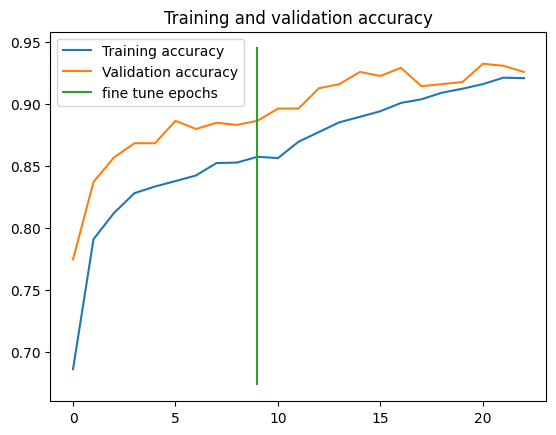

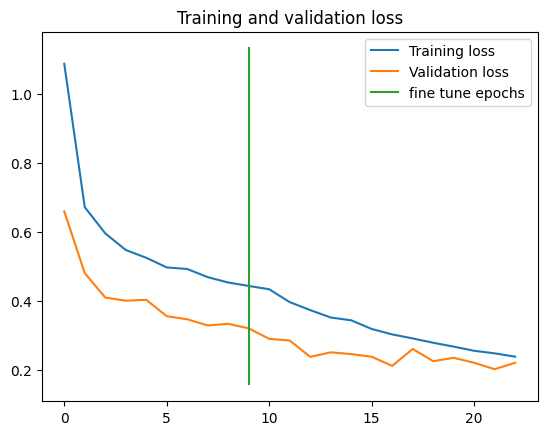

In [23]:
compare_historys(history_1, history_2)

**Evaluate on test data:**

In [24]:
model_1.evaluate(test_data)

79/79 [==============================] - 14s 172ms/step - loss: 0.2333 - accuracy: 0.9268


[0.23330998420715332, 0.926800012588501]

**Make predictions:**

In [25]:
model_1_pred_probs = model_1.predict(test_data)# for prediction we need shape of data to be (none, 224, 224, 3)

79/79 [==============================] - 16s 184ms/step


**Check the labels of our predictions:**

In [26]:
model_1_preds = model_1_pred_probs.argmax(axis = 1)
model_1_preds

array([0, 0, 0, ..., 9, 9, 9])

**Unbatch the data and find out their labels:**

In [27]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:3], y_labels[-3:]

([0, 0, 0], [9, 9, 9])

**Check for accuracy score:**

In [28]:
sklearn_accuracy = accuracy_score(y_labels, model_1_preds)
print(f"We're getting an accuracy of {sklearn_accuracy * 100}% on out test data")

We're getting an accuracy of 92.67999999999999% on out test data


**Check for the confusion metrics:**

In [29]:
conf_matrix = confusion_matrix(y_labels, model_1_preds)
conf_matrix

array([[225,   4,   4,   4,   2,   0,   0,   7,   1,   3],
       [  3, 241,   0,   2,   1,   0,   0,   1,   2,   0],
       [ 16,   0, 219,   3,   0,   2,   0,   6,   3,   1],
       [  8,   3,   2, 216,   3,   0,   0,   4,  10,   4],
       [  1,   0,   0,   2, 239,   0,   0,   0,   8,   0],
       [  2,   3,   0,   3,   2, 235,   1,   1,   1,   2],
       [  5,   0,   0,   1,   3,   0, 241,   0,   0,   0],
       [  6,   0,   0,   2,   0,   0,   0, 242,   0,   0],
       [  2,   3,   0,  13,   4,   0,   0,   3, 225,   0],
       [  1,   0,   1,   6,   2,   1,   1,   1,   3, 234]])

In [30]:
class_names = test_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

**Plot the confusioin metrics:**

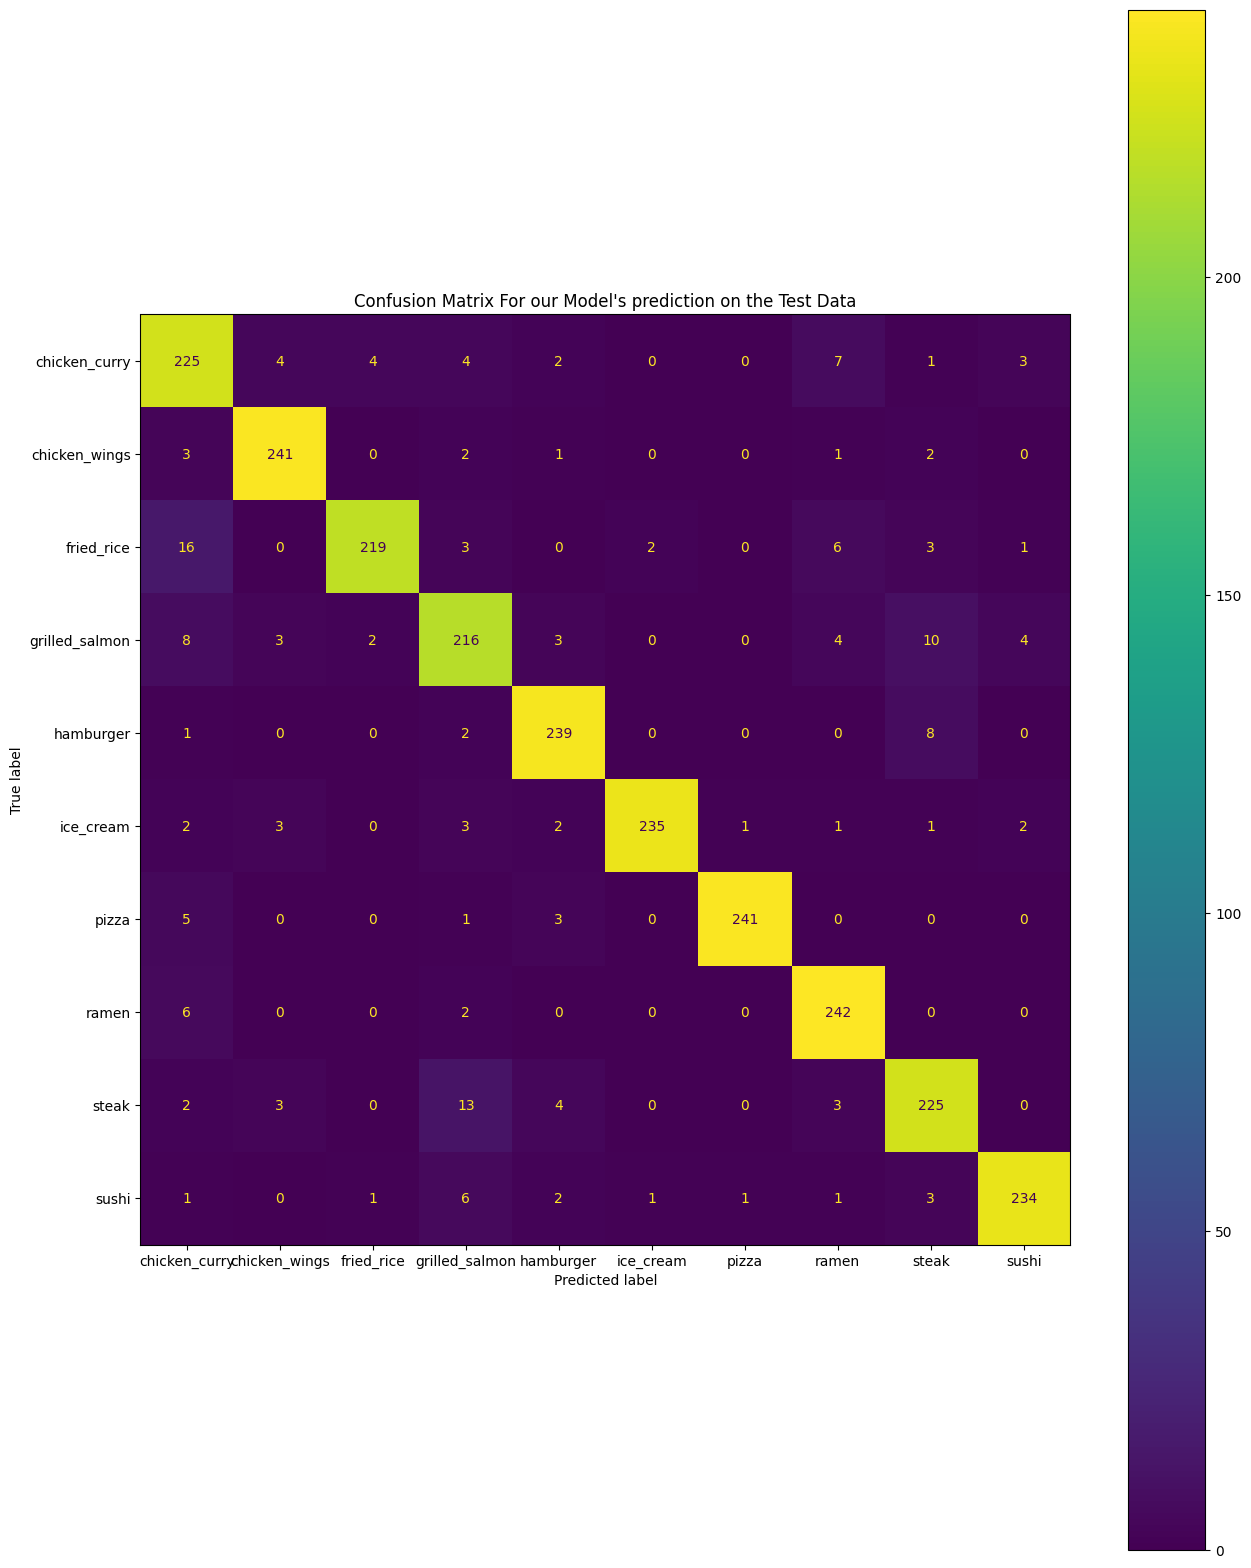

In [36]:
fig, ax = plt.subplots(figsize = (15, 20), dpi = 100)
display = ConfusionMatrixDisplay(conf_matrix, display_labels = class_names)
ax.set(title = "Confusion Matrix For our Model's prediction on the Test Data")
display.plot(ax = ax);

**A function to prepare our image for prediction:**

In [32]:
def load_and_prep_image(filename, img_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

**A function to make prediction and view our prediction:**

In [59]:
def pred_and_plot(model, filename, class_name = class_names):
  img = load_and_prep_image(filename, scale = False)
  pred_probs = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_probs.argmax()]
  plt.imshow(img/255.)
  plt.title(f"Pred class: {pred_class}")
  plt.axis(False)
  return pred_class

**Make predictions on some images from test data:**

1/1 [==============================] - 0s 60ms/step


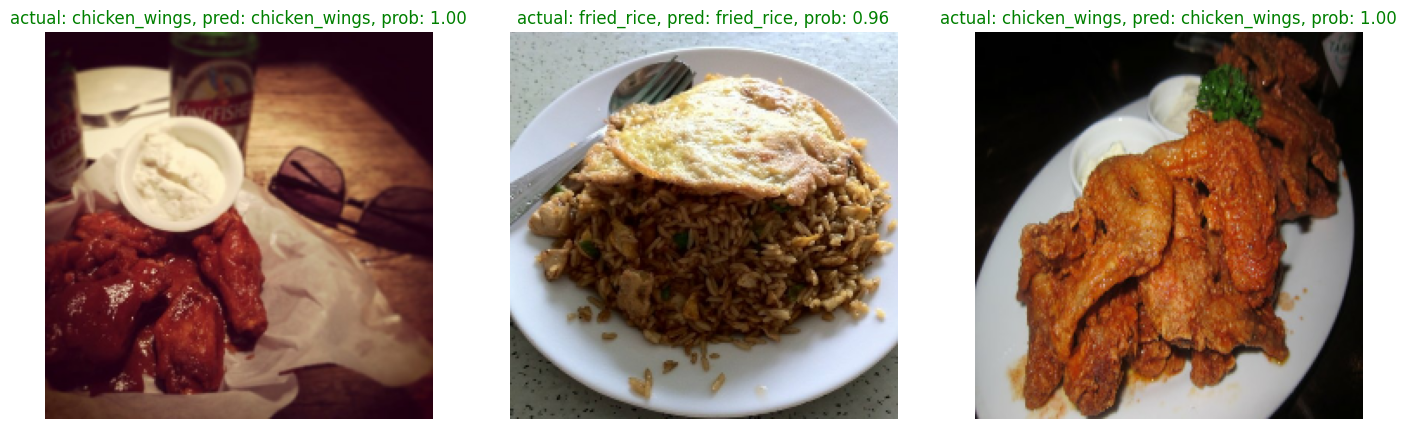

In [43]:
# Make preds on a series of random images
import os
import random
test_dir = '/kaggle/working/10_food_classes_all_data/test/'
plt.figure(figsize=(17, 10))
for i in range(3): 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False) 
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()]  

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

**Make some predictions from images downloaded from the wild:**

> 1.)

1/1 [==============================] - 0s 61ms/step


'hamburger'

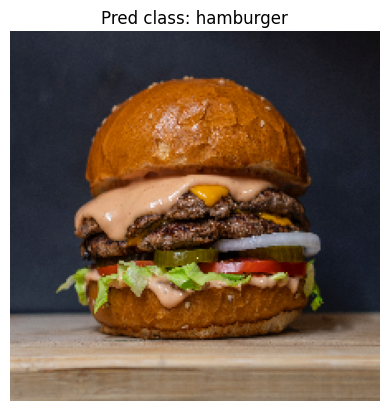

In [60]:
pred_and_plot(model_1, '/kaggle/input/test-images2/amirali-mirhashemian-sc5sTPMrVfk-unsplash.jpg')

> 2.)

1/1 [==============================] - 0s 62ms/step


'fried_rice'

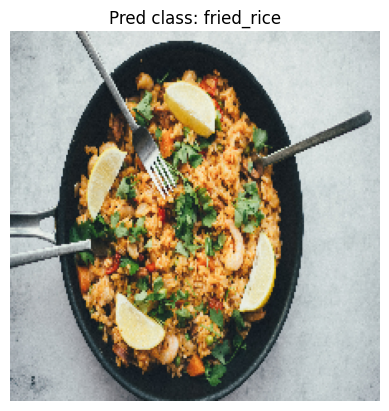

In [61]:
pred_and_plot(model_1, '/kaggle/input/test-images2/annie-spratt-oT7_v-I0hHg-unsplash.jpg')

> 3.)

1/1 [==============================] - 0s 62ms/step


'chicken_curry'

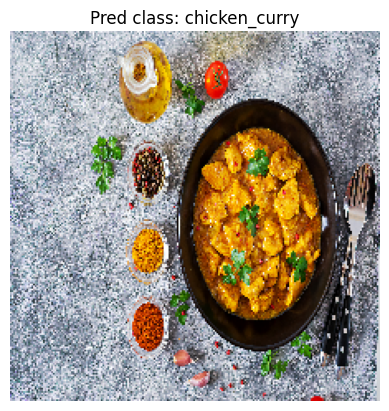

In [62]:
pred_and_plot(model_1, '/kaggle/input/test-images2/curry-with-chicken-onions-indian-food-asian-cuisine-top-view.jpg')

> 4.)

1/1 [==============================] - 0s 60ms/step


'ice_cream'

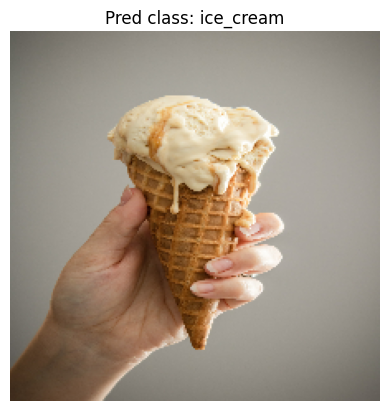

In [63]:
pred_and_plot(model_1, '/kaggle/input/test-images2/dana-devolk-5-RS_ScO3X4-unsplash.jpg')

> 5.)

1/1 [==============================] - 0s 65ms/step


'chicken_wings'

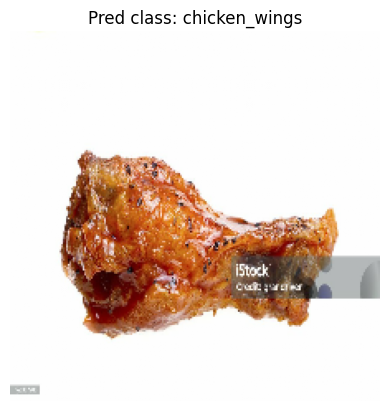

In [64]:
pred_and_plot(model_1, '/kaggle/input/test-images3/istockphoto-168307283-1024x1024.jpg')

> 6.)

1/1 [==============================] - 0s 63ms/step


'steak'

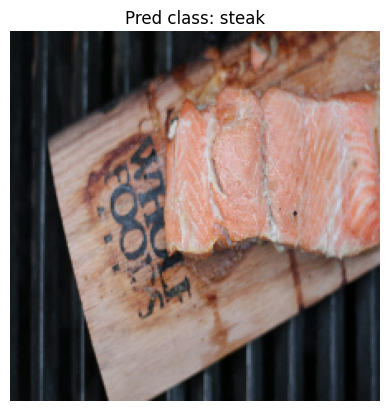

In [65]:
pred_and_plot(model_1, '/kaggle/input/test-images3/janeris-marte-RbE7eW-C8oU-unsplash.jpg')

> 7.)

1/1 [==============================] - 0s 63ms/step


'sushi'

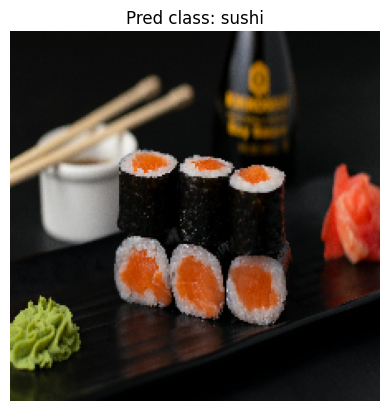

In [66]:
pred_and_plot(model_1, '/kaggle/input/test-images3/mahmoud-fawzy-FBezBX26dyY-unsplash.jpg')

> 8.)

1/1 [==============================] - 0s 66ms/step


'steak'

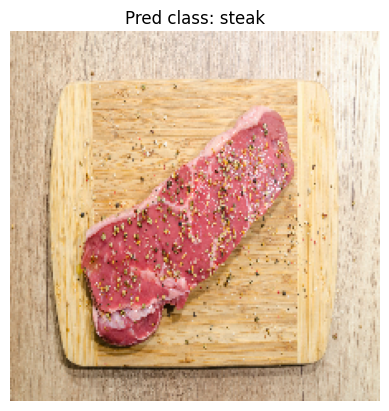

In [67]:
pred_and_plot(model_1, '/kaggle/input/test-images3/pexels-lukas-618775.jpg')

> 9.)

1/1 [==============================] - 0s 61ms/step


'ramen'

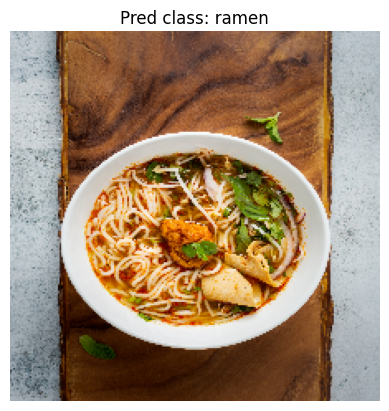

In [68]:
pred_and_plot(model_1, '/kaggle/input/ramen-image1/mae-mu-H5Hj8QV2Tx4-unsplash.jpg')